In [3]:
%load_ext autoreload
%autoreload 2

In [20]:
from typing import Any, Dict, List, Optional, Tuple

import hydra,pickle
import lightning as L
import rootutils
import numpy as np
import torch
from lightning import Callback, LightningDataModule, LightningModule, Trainer
from lightning.pytorch.loggers import Logger
from omegaconf import DictConfig
# from src.data.scared_datamodule
root = rootutils.setup_root('./', indicator=".project-root", pythonpath=True)
print(root)

/bd_byta6000i0/users/surgical_depth/surgical_depth


In [5]:
from src.models import resnet18, DinoEncoder, R2Plus1D, DPTHead

/bd_byta6000i0/users/surgical_depth/.micromamba_data/envs/sd/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/bd_byta6000i0/users/surgical_depth/.micromamba_data/envs/sd/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [7]:
RD = R2Plus1D([2,2,2,2])

In [8]:
with open('batch.pkl', 'rb') as f:
    batch = pickle.load(f)

In [24]:
feature = RD(batch[('color_clip', 0)])

[autoreload of lightning.fabric.strategies.single_tpu failed: Traceback (most recent call last):
  File "/bd_byta6000i0/users/surgical_depth/.micromamba_data/envs/sd/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/bd_byta6000i0/users/surgical_depth/.micromamba_data/envs/sd/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/bd_byta6000i0/users/surgical_depth/.micromamba_data/envs/sd/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/bd_byta6000i0/users/surgical_depth/.micromamba_data/envs/sd/lib/python3.10/site-packages/lightning/fabric/_graveyard/tpu.py", line 121, 

In [25]:
for item in feature:
    print(item.shape)

torch.Size([12, 96, 5, 112, 140])
torch.Size([12, 192, 5, 56, 70])
torch.Size([12, 384, 5, 28, 35])
torch.Size([12, 768, 5, 14, 18])


In [29]:
merged_lists = [[] for _ in range(5)]

# 拆分并按照第三个维度合并
for tensor in feature:
    for i in range(5):
        merged_lists[i].append(tensor[:, :, i, :, :])

# 打印每个合并后的列表的大小
for i, merged_list in enumerate(merged_lists):
    print(f"List {i+1} size: {len(merged_list)}")

List 1 size: 4
List 2 size: 4
List 3 size: 4
List 4 size: 4
List 5 size: 4


In [28]:
len(merged_lists)

5

In [32]:
for item in merged_lists[4]:
    print(item.shape)

torch.Size([12, 96, 112, 140])
torch.Size([12, 192, 56, 70])
torch.Size([12, 384, 28, 35])
torch.Size([12, 768, 14, 18])


In [10]:
head = DPTHead(1)

In [27]:
result = head.temporal_forward(feature, 16, 20)

In [18]:
result.max()

tensor(0.8872, grad_fn=<MaxBackward1>)

In [14]:
mask = (result > 10) & (result < 150)

In [17]:
result[mask]

tensor([], grad_fn=<IndexBackward0>)

In [41]:
batch[('color_clip',0)].shape

torch.Size([12, 3, 5, 224, 280])

In [46]:
result = head.temporal_forawrd(feature, 16, 20)

In [48]:
for item in result:
    print(item.shape)

torch.Size([12, 1, 224, 280])
torch.Size([12, 1, 224, 280])
torch.Size([12, 1, 224, 280])
torch.Size([12, 1, 224, 280])
torch.Size([12, 1, 224, 280])


In [57]:
torch.stack(result).permute(1,2,0,3,4).shape

torch.Size([12, 1, 5, 224, 280])

In [90]:
batch[('depth_gt'), 0][0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [65]:
from torchvision import transforms

In [66]:
topil = transforms.ToPILImage()

In [39]:
import cv2

In [57]:
image = cv2.imread('/bd_byta6000i0/users/surgical_depth/SCARED_fixed/dataset7/keyframe4/image_02/data/groundtruth/scene_points000450.tiff',3)

In [58]:
depth_gt = image[:, :, 0]
gt_depth = depth_gt[0:1024, :]

In [59]:
gt_depth.max()

135.35512

In [43]:
gt_depth

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [5]:
import matplotlib.pyplot as plt

In [46]:
ar = np.load('/bd_byta6000i0/users/surgical_depth/AF-SfMLearner/truth/533.npy')

In [47]:
ar.max()

135.5377

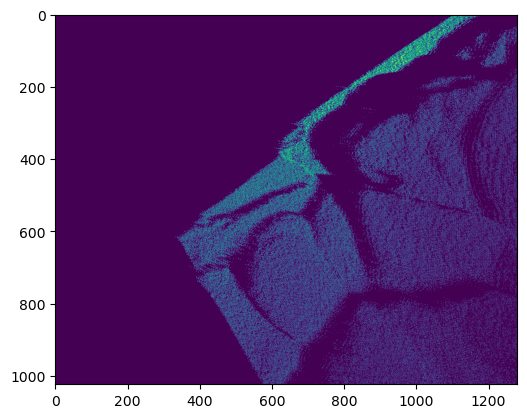

In [60]:
plt.imshow(gt_depth)

In [85]:
gt_depth.min()

nan

In [89]:
torch.from_numpy(gt_depth.astype(np.float32)).max()

tensor(nan)

In [2]:
import torch
import torch.nn.functional as F

# 假设你有一个大小为torch.Size([12, 1, 5, 224, 280])的张量
input_tensor = torch.randn(12, 1, 5, 224, 280)

# 目标大小
target_size = (1024, 1280)

# 计算每个维度上的缩放比例
scale_factors = [target_size[0] / input_tensor.size(3), target_size[1] / input_tensor.size(4)]

# 执行插值操作
output_tensor = F.interpolate(input_tensor, scale_factor=scale_factors, mode='nearest')

# 输出新张量的大小
print(output_tensor.size())  # torch.Size([12, 1, 5, 1024, 1280])

ValueError: Input and scale_factor must have the same number of spatial dimensions, but got input with spatial dimensions of [5, 224, 280] and scale_factor of shape [4.571428571428571, 4.571428571428571]. Please provide input tensor in (N, C, d1, d2, ...,dK) format and scale_factor in (s1, s2, ...,sK) format.

In [21]:
a = [1,1]

In [22]:
for b in a:
    b *= 2

In [23]:
a

[1, 1]